In [1]:
import requests
import pandas as pd
from functools import reduce
from sqlalchemy import create_engine, text
import json
import ast
from datetime import datetime
import matplotlib.pyplot as plt 
import seaborn as sns

D:\Users\harsh\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
path = 'db_config.json'
with open(path,'r') as f:
    db_config = json.load(f)

In [3]:
db_cnx = create_engine(f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['ip']}/{db_config['db_name']}", 
                       pool_recycle=3600)

In [4]:
def fn_update_source_audit(source_name, last_refresh_dt, last_exec_dt, tot_exec_time, db_cnx):
    # Use SQLAlchemy's text() to make the query executable
    qry = text("""
        UPDATE source_audit
        SET 
            last_refresh_dt = :last_refresh_dt,
            last_exec_dt = :last_exec_dt,
            tot_exec_time = :tot_exec_time
        WHERE source_name = :source_name
    """)
    
    # Execute the query with parameters as a dictionary
    with db_cnx.connect() as connection:
        connection.execute(qry, {
            'last_refresh_dt': last_refresh_dt,
            'last_exec_dt': last_exec_dt,
            'tot_exec_time': tot_exec_time,
            'source_name': source_name
        })
        connection.commit()


#update_source_audit(last_refresh_dt, last_run_dt, last_exec_time, source_name, db_cnx)


def fn_insert_task_audit(source_name,last_exec_dt,exec_time, db_cnx):
    task_dict = {
        'task_name' : {source_name},
        'last_exec_dt' : {last_exec_dt},
        'flg_success' : 1,
        'exec_time' : {exec_time}
    }
    df = pd.DataFrame([task_dict])
    df.to_sql('task_audit', db_cnx, if_exists='append', index=False)
    
#insert_task_audit(source_name,last_exec_dt,exec_time, db_cnx) 




def fn_insert_source_info(source_name, last_refresh_dt, time_zone, info):
    source_dict = {
        'source_name': [source_name],  
        'last_refresh_dt': [last_refresh_dt],  
        'time_zone': ['US/Eastern'],  
        'info': [info] 
    }

    df = pd.DataFrame(source_dict)

    df.to_sql('source_info', db_cnx, if_exists='append', index=False)


#insert_source_info(source_name,last_refresh_dt,time_zone,info)    

In [5]:
def fn_get_inc_df(stock_data_df, source_name, db_cnx):
    sql_qry = f"""
        select last_refresh_dt
        from source_audit
        where source_name = '{source_name}';
    """
    sql_df = pd.read_sql_query(sql_qry,db_cnx)
    
    last_refresh_dt = sql_df['last_refresh_dt'][0]
    last_refresh_dt = pd.Timestamp(last_refresh_dt)
    return stock_data_df[stock_data_df['trade_dt'] >= last_refresh_dt]

In [6]:
def fn_insert_stock_date(df, source_name, db_cnx):
    df['stock_info'] = df['stock_info'].apply(json.dumps)
    
    source_name = source_name.lower()
    df.to_sql(f'st_stock_{source_name}_info', db_cnx, if_exists='replace', index=False)
    
    db_procedure_name = f'sp_stock_{source_name}'
    with db_cnx.connect() as connection:
        connection.execute(text(f'CALL {db_procedure_name}()'))

In [7]:
def fn_fetch_data(source_name, db_cnx):
    start_time = datetime.now()
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={source_name}&outputsize=full&apikey=J9M3DNRBBYIK9GXN'
    r = requests.get(url)
    data = r.json()
    df = pd.DataFrame(data)
    
    ########### 
    ## info df
    info_df = df[df['Time Series (Daily)'].isna()].reset_index()

    ## Last Refresh Date
    last_refresh_dt = info_df.loc[
        info_df['index'].str.contains('last refreshed', case=False, na=False), 
        'Meta Data'
    ].iloc[0]
    
    info = info_df.loc[
        info_df['index'].str.contains('information', case=False, na=False), 
        'Meta Data'
    ].iloc[0]
    
    time_zone = info_df.loc[
        info_df['index'].str.contains('time zone', case=False, na=False), 
        'Meta Data'
    ].iloc[0]

    ## Last Execution Date
    last_exec_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    ### Total Running Time for Fucntion
    end_time = datetime.now()
    tot_exec_time = (end_time - start_time).total_seconds()
    
    #### fn_update_source_audit
    fn_update_source_audit(source_name, last_refresh_dt, last_exec_dt, tot_exec_time, db_cnx)
    
    #### fn_insert_task_audit
    fn_insert_task_audit(source_name, last_exec_dt, tot_exec_time, db_cnx)
    
    #### fn_insert_source_info
    fn_insert_source_info(source_name, last_refresh_dt, time_zone, info)
    
    
    stock_data_df = df[~df['Time Series (Daily)'].isna()].reset_index()[['index','Time Series (Daily)']]
    stock_data_df.columns = ['trade_dt','stock_info']
    stock_data_df['trade_dt'] = pd.to_datetime(stock_data_df['trade_dt'])
    
    stock_data_df = fn_get_inc_df(stock_data_df, source_name, db_cnx)
    ### TO Insert The Whole Data
    #     fn_insert_stock_date(stock_data_df, source_name, db_cnx)
    
#     fn_insert_stock_date(stock_data_df[0:11], source_name, db_cnx)
    fn_insert_stock_date(stock_data_df, source_name, db_cnx)

source_list = ['TSLA', 'AMZN', 'IBM', 'MSFT', 'AAPL']    
for source_name in source_list:
    # source_name = 'AAPL'
    fn_fetch_data(source_name, db_cnx)

### Visulization

#### Data Load Functions

In [58]:
def fn_load_data(table_name, db_cnx):
    try:
        qry = f"""
            select *
            from stock_{table_name}_info;
        """
        df = pd.read_sql_query(qry, db_cnx)
        return df
    
    ### IF table does not exist or some other errors , error handling
    except Exception as e:
        print(f"{table_name} did not load properly. Check this error {e}")

#### Data Transformation Functions

In [59]:
def safe_literal_eval(x):
        try:
            return ast.literal_eval(x)
        except Exception as e:
            try :
                return json.loads(x)
            except:
                return None

def fn_data_transformations(df):
    df['updated_stock_info'] = df['stock_info'].apply(safe_literal_eval)
    
    json_df = pd.json_normalize(df['updated_stock_info'])
    json_df.columns = json_df.columns.str.replace(r'^\d+\.\s*', '', regex=True)
    
    result = pd.merge(df,json_df,right_index=True,left_index=True)
    result = result[['trade_dt','open','close','high','low','volume']]
    
    result['trade_dt'] = pd.to_datetime(result['trade_dt'])
    result['open'] = result['open'].astype('float')
    result['close'] = result['close'].astype('float')
    result['high'] = result['high'].astype('float')
    result['low'] = result['low'].astype('float')
    result['volume'] = pd.to_numeric(result['volume'], errors='coerce')  # Converts invalid values to NaN
    result['volume'] = result['volume'].fillna(0).astype('Int64')  # Fill NaN with 0 and convert to Int64
    
    
    ### Also adding Mth_id and Year_id for further Analysis
    result['mth_id'] = result['trade_dt'].dt.year * 100 + result['trade_dt'].dt.month
    result['year_id'] = result['trade_dt'].dt.year
    return result

In [60]:
def fn_grp_trans(df, source_name, grp_key):
    grp_df = df.groupby(grp_key).agg({
        'open' : 'first',
        'close' : 'last',
        'high' : 'max',
        'low' : 'min',
        'volume' : 'sum'
    }).reset_index()
    grp_df.columns = [grp_key, f'{source_name}_open', f'{source_name}_close', f'{source_name}_high',
                         f'{source_name}_low', f'{source_name}_volume']
    
    grp_df[f'{source_name}_pct_change'] = grp_df[f'{source_name}_close'].pct_change() * 100

    return grp_df

In [61]:
source_list = ['TSLA', 'AMZN', 'IBM', 'MSFT', 'AAPL']
source_list = list(map(str.lower, source_list))  ### Every Company name in lower case


sources_daily_dict = {}
sources_mtly_dict = {}
sources_yearly_dict = {}

### Load Data
for source_name in source_list:
    sources_daily_dict[source_name] = fn_load_data(source_name, db_cnx)
# sources_daily_dict    
# print(sources_daily_dict.keys())

### Transform Data
for name, df in sources_daily_dict.items():
    sources_daily_dict[name] = fn_data_transformations(df)
    
    sources_mtly_dict[name] = fn_grp_trans(sources_daily_dict[name], name, 'mth_id')
    
    sources_yearly_dict[name] = fn_grp_trans(sources_daily_dict[name], name, 'year_id')

In [62]:
sources_yearly_dict.keys()

dict_keys(['tsla', 'amzn', 'ibm', 'msft', 'aapl'])

### Merging Data

In [63]:
merged_mthly_data = reduce(lambda left, right: pd.merge(left, right, on= 'mth_id',how='outer'), sources_mtly_dict.values())

merged_mthly_data = merged_mthly_data[merged_mthly_data['mth_id'] > 201012]
# merged_mthly_data.to_excel('monthly.xlsx',index=False)

In [64]:
merged_yearly_data = reduce(lambda left, right: pd.merge(left, right, on= 'year_id',how='outer'), sources_yearly_dict.values())

merged_yearly_data = merged_yearly_data[merged_yearly_data['year_id'] > 2010]
# merged_yearly_data.to_excel('yearly.xlsx',index=False)

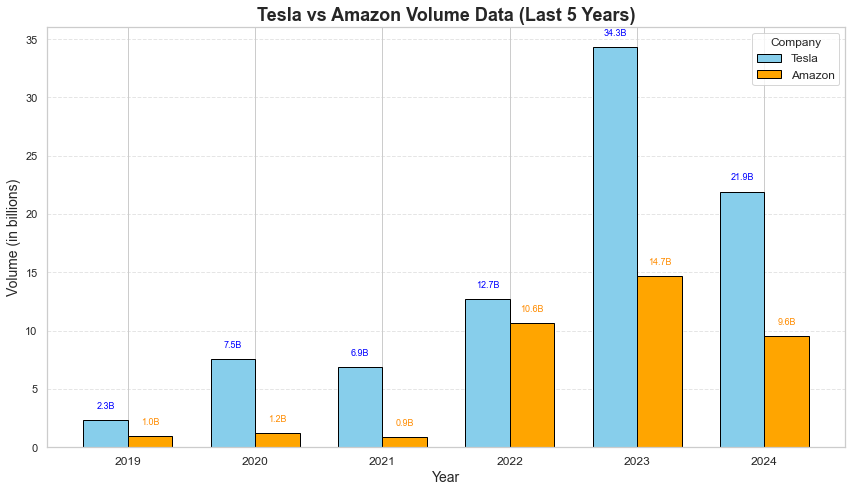

In [65]:
df = merged_yearly_data[['year_id','tsla_volume','amzn_volume','ibm_volume','msft_volume','aapl_volume']]
df = merged_yearly_data[merged_yearly_data['year_id'] > 2018][['year_id',  'tsla_volume', 'amzn_volume']]

df.set_index('year_id', inplace=True)
sns.set_theme(style="whitegrid")

# Create the bar chart
plt.figure(figsize=(12, 7))
bar_width = 0.35
x_positions = range(len(df.index))

# Plot Tesla volumes
plt.bar(x_positions, df['tsla_volume'] / 1e9, width=bar_width, color='skyblue', label='Tesla', edgecolor='black')
# Plot Amazon volumes
plt.bar([x + bar_width for x in x_positions], df['amzn_volume'] / 1e9, width=bar_width, color='orange', label='Amazon', edgecolor='black')


for i, (tsla, amzn) in enumerate(zip(df['tsla_volume'], df['amzn_volume'])):
    plt.text(i, tsla / 1e9 + 1, f"{tsla / 1e9:.1f}B", ha='center', fontsize=9, color='blue')
    plt.text(i + bar_width, amzn / 1e9 + 1, f"{amzn / 1e9:.1f}B", ha='center', fontsize=9, color='darkorange')

plt.title('Tesla vs Amazon Volume Data (Last 5 Years)', fontsize=18, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Volume (in billions)', fontsize=14)
plt.xticks([x + bar_width / 2 for x in x_positions], df.index, fontsize=12)
plt.legend(title='Company', fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()


In [66]:
# # 1. Tesla's Growth vs Peers: Normalized Closing Prices
# plt.figure(figsize=(14, 8))
# for company in source_list:
#     merged_mthly_data[f'{company}_normalized'] = merged_mthly_data[f'{company}_close'] / merged_mthly_data[f'{company}_close'].iloc[0] * 100
#     plt.plot(merged_mthly_data['mth_id'], merged_mthly_data[f'{company}_normalized'], label=company)
# plt.title("Normalized Stock Closing Prices Over Time", fontsize=16)
# plt.xlabel("Date", fontsize=14)
# plt.ylabel("Normalized Closing Price (%)", fontsize=14)
# plt.legend(title="Company")
# plt.grid()
# plt.show()

In [67]:
merged_mthly_data['year_id'] = (round(merged_mthly_data['mth_id']/100))
merged_mthly_data['year_id'] = merged_mthly_data['year_id'].astype('Int64')
merged_mthly_data

,mth_id,tsla_open,tsla_close,tsla_high,tsla_low,tsla_volume,tsla_pct_change,amzn_open,amzn_close,amzn_high,...,msft_low,msft_volume,msft_pct_change,aapl_open,aapl_close,aapl_high,aapl_low,aapl_volume,aapl_pct_change,year_id
7,201101,26.840,24.10,28.710,22.37,28420100,-9.500563,181.370,169.64,191.60,...,27.4200,1361258700,-0.662845,325.640,339.3200,348.60,324.8365,387197700,5.195933,2011
8,201102,24.310,23.89,25.490,21.11,29303500,-0.871369,170.520,173.29,191.40,...,26.4300,1114368500,-4.129847,341.300,353.2100,364.90,337.7200,331998200,4.093481,2011
9,201103,24.050,27.75,28.710,21.77,32563300,16.157388,173.530,180.13,181.57,...,24.6800,1310885200,-4.477050,355.470,348.5075,361.67,326.2600,403802100,-1.331361,2011
10,201104,27.450,27.60,28.180,24.20,29894900,-0.540541,181.580,195.81,197.80,...,24.7200,1313844800,2.087436,351.110,350.1300,355.13,320.1600,330493900,0.465557,2011
11,201105,27.600,30.14,30.280,25.52,30348800,9.202899,196.570,196.69,206.39,...,24.0300,1364062800,-3.510802,349.740,347.8300,351.83,329.4200,246859300,-0.656899,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,202407,201.020,232.07,271.000,200.85,2946645956,17.278148,193.490,186.98,201.20,...,412.2100,440446499,-6.398926,212.090,222.0800,237.23,211.9200,1153193377,5.441079,2024
170,202408,227.690,214.11,231.867,182.00,1618373088,-7.739044,189.285,178.50,190.60,...,385.5800,451919023,-0.289232,224.370,229.0000,232.92,196.0000,1122666993,3.115994,2024
171,202409,215.260,261.63,264.860,209.64,1611006644,22.194199,177.550,186.33,195.37,...,400.8000,376719438,3.154816,228.550,233.0000,233.09,213.9200,1231814423,1.746725,2024
172,202410,262.670,249.85,273.536,212.11,1910960826,-4.502542,184.900,186.40,195.61,...,406.3000,440766715,-5.565884,229.520,225.9100,237.49,221.3300,930835961,-3.042918,2024


In [68]:
df = merged_mthly_data
df

,mth_id,tsla_open,tsla_close,tsla_high,tsla_low,tsla_volume,tsla_pct_change,amzn_open,amzn_close,amzn_high,...,msft_low,msft_volume,msft_pct_change,aapl_open,aapl_close,aapl_high,aapl_low,aapl_volume,aapl_pct_change,year_id
7,201101,26.840,24.10,28.710,22.37,28420100,-9.500563,181.370,169.64,191.60,...,27.4200,1361258700,-0.662845,325.640,339.3200,348.60,324.8365,387197700,5.195933,2011
8,201102,24.310,23.89,25.490,21.11,29303500,-0.871369,170.520,173.29,191.40,...,26.4300,1114368500,-4.129847,341.300,353.2100,364.90,337.7200,331998200,4.093481,2011
9,201103,24.050,27.75,28.710,21.77,32563300,16.157388,173.530,180.13,181.57,...,24.6800,1310885200,-4.477050,355.470,348.5075,361.67,326.2600,403802100,-1.331361,2011
10,201104,27.450,27.60,28.180,24.20,29894900,-0.540541,181.580,195.81,197.80,...,24.7200,1313844800,2.087436,351.110,350.1300,355.13,320.1600,330493900,0.465557,2011
11,201105,27.600,30.14,30.280,25.52,30348800,9.202899,196.570,196.69,206.39,...,24.0300,1364062800,-3.510802,349.740,347.8300,351.83,329.4200,246859300,-0.656899,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,202407,201.020,232.07,271.000,200.85,2946645956,17.278148,193.490,186.98,201.20,...,412.2100,440446499,-6.398926,212.090,222.0800,237.23,211.9200,1153193377,5.441079,2024
170,202408,227.690,214.11,231.867,182.00,1618373088,-7.739044,189.285,178.50,190.60,...,385.5800,451919023,-0.289232,224.370,229.0000,232.92,196.0000,1122666993,3.115994,2024
171,202409,215.260,261.63,264.860,209.64,1611006644,22.194199,177.550,186.33,195.37,...,400.8000,376719438,3.154816,228.550,233.0000,233.09,213.9200,1231814423,1.746725,2024
172,202410,262.670,249.85,273.536,212.11,1910960826,-4.502542,184.900,186.40,195.61,...,406.3000,440766715,-5.565884,229.520,225.9100,237.49,221.3300,930835961,-3.042918,2024


In [69]:
df1 = pd.melt(
    df,
    id_vars = ['year_id', 'mth_id'],
    value_vars = df.filter(like='_close').columns,
    var_name = 'company',
    value_name = 'close_price'
)
df1['company'] = df1['company'].str.replace('_close','')

df2 = pd.melt(
    df,
    id_vars = ['year_id', 'mth_id'],
    value_vars = df.filter(like='_open').columns,
    var_name = 'company',
    value_name = 'open_price'
)
df2['company'] = df2['company'].str.replace('_open','')
df3 = pd.melt(
    df,
    id_vars = ['year_id', 'mth_id'],
    value_vars = df.filter(like='_high').columns,
    var_name = 'company',
    value_name = 'high_price'
)
df3['company'] = df3['company'].str.replace('_high','')


df4 = pd.melt(
    df,
    id_vars = ['year_id', 'mth_id'],
    value_vars = df.filter(like='_low').columns,
    var_name = 'company',
    value_name = 'low_price'
)
df4['company'] = df4['company'].str.replace('_low','')


df5 = pd.melt(
    df,
    id_vars = ['year_id', 'mth_id'],
    value_vars = df.filter(like='_volume').columns,
    var_name = 'company',
    value_name = 'volume'
)
df5['company'] = df5['company'].str.replace('_volume','')


df6 = pd.melt(
    df,
    id_vars = ['year_id', 'mth_id'],
    value_vars = df.filter(like='_pct_change').columns,
    var_name = 'company',
    value_name = 'pct_change'
)
df6['company'] = df6['company'].str.replace('_pct_change','')


df_result = reduce(lambda left, right: pd.merge(left, right, on=['year_id','mth_id','company']),
                   [df1, df2, df3, df4, df5, df6])

del df1
del df2 
del df3
del df4
del df5 
del df6

df_result

,year_id,mth_id,company,close_price,open_price,high_price,low_price,volume,pct_change
0,2011,201101,tsla,24.10,26.840,28.71,22.37,28420100,-9.500563
1,2011,201102,tsla,23.89,24.310,25.49,21.11,29303500,-0.871369
2,2011,201103,tsla,27.75,24.050,28.71,21.77,32563300,16.157388
3,2011,201104,tsla,27.60,27.450,28.18,24.20,29894900,-0.540541
4,2011,201105,tsla,30.14,27.600,30.28,25.52,30348800,9.202899
...,...,...,...,...,...,...,...,...,...
830,2024,202407,aapl,222.08,212.090,237.23,211.92,1153193377,5.441079
831,2024,202408,aapl,229.00,224.370,232.92,196.00,1122666993,3.115994
832,2024,202409,aapl,233.00,228.550,233.09,213.92,1231814423,1.746725
833,2024,202410,aapl,225.91,229.520,237.49,221.33,930835961,-3.042918


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets, interactive, fixed

# Widgets
Variable1 = widgets.Dropdown(
    options=list(df_result.columns),
    value='mth_id',
    description='Grp_var',
)

Variable4 = widgets.Dropdown(
    options=list(df_result.columns),
    value='close_price', 
    description='Column',
)

Variable2 = widgets.Dropdown(
    options=['no_agg_fun', 'min', 'max', 'first', 'last', 'sum', 'mean'],
    value='mean',
    description='agg_functions',
)

Variable3 = widgets.Dropdown(
    options=['all_year'] + list(df_result['year_id'].unique()),
    value='all_year',
    description='Year',
)

Variable5 = widgets.SelectMultiple(
    options=['all_company'] + list(df_result['company'].unique()),
    value=('all_company',),
    description='Company',
    style={'description_width': 'initial'},
)

# Updated plotting function
def plot_sales_trend(df, grp_var, col_name, agg_fun, year_id, company_name):
    if year_id != 'all_year':
        df = df[df['year_id'] == year_id]
    
    if 'all_company' in company_name:
        companies_to_plot = df['company'].unique()
    else:
        companies_to_plot = company_name
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 8))  
    
    colors = sns.color_palette("husl", len(companies_to_plot))  
    
    # Plot each company
    for idx, company in enumerate(companies_to_plot):
        company_data = df[df['company'] == company]
        if agg_fun != 'no_agg_fun':
            grp_df = company_data.groupby(grp_var, as_index=False)[col_name].agg(agg_fun)
        else:
            grp_df = company_data[[grp_var, col_name]].drop_duplicates()
        
        plt.plot(
            grp_df[grp_var], 
            grp_df[col_name], 
            label=company,
            marker='o', 
            linestyle='-', 
            color=colors[idx], 
            linewidth=2,  
            markersize=6  
        )
    
    plt.title(f"Sales Trend ({agg_fun} of {col_name}) for Year {year_id}", fontsize=18, fontweight='bold')
    plt.xlabel(grp_var, fontsize=14, fontweight='bold')
    plt.ylabel(col_name, fontsize=14, fontweight='bold')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="Companies", fontsize=12, title_fontsize='13', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()  
    plt.show()


# Fix the DataFrame for the interactive chart
class fixed_copy(fixed):
    def get_interact_value(self):
        return self.value.copy()

# Interactive widget
interactive_plot = interactive(
    plot_sales_trend,
    df=fixed_copy(df_result),
    grp_var=Variable1,
    col_name=Variable4,
    agg_fun=Variable2,
    year_id=Variable3,
    company_name=Variable5
)

interactive_plot


interactive(children=(Dropdown(description='Grp_var', index=1, options=('year_id', 'mth_id', 'company', 'close…

## Final Chart

In [74]:
import pandas as pd
import plotly.express as px

df_yearly = df_result.groupby(['year_id', 'company'])['close_price'].last().reset_index()


df_yearly['normalized_close'] = df_yearly.groupby('company')['close_price'].transform(
    lambda x: (x / x.iloc[0]) * 100
)

# companies = ['tsla', 'amzn', 'ibm', 'msft', 'aapl']

companies = ['tsla', 'amzn', 'ibm', 'msft', 'aapl']
colors = sns.color_palette("husl", len(companies))
color_map = {company: colors[idx] for idx, company in enumerate(companies)}

df_filtered = df_yearly[df_yearly['company'].isin(companies)]


fig = px.line(
    df_filtered,
    x='year_id',
    y='normalized_close',
    color='company',
    markers=True,
    title="Normalized Stock Closing Prices Over Time (Yearly)",
    labels={
        "year_id": "Year",
        "normalized_close": "Normalized Closing Price (%)",
        "company": "Company"
    },
    color_discrete_map={company: f'rgb({int(color[0] * 255)}, {int(color[1] * 255)}, {int(color[2] * 255)})' for company, color in color_map.items()}  # Map colors to Plotly format
)


fig.update_layout(
#     title_font_size=18,
#     xaxis_title_font_size=16,
#     yaxis_title_font_size=16,
#     legend_title_font_size=14,
    hovermode="x unified",  # Show hover labels for all lines at once
#     xaxis=dict(
#         gridcolor="gray",  # Match Matplotlib grid color
#         gridwidth=0.7  # Solid grid lines
#     ),
#     yaxis=dict(
#         gridcolor="gray",  # Match Matplotlib grid color
#         gridwidth=0.7  # Solid grid lines
#     ),
    title=dict(
        text="Normalized Stock Closing Prices Over Time (Yearly)",
        font=dict(size=20, color="black", family="Arial", weight="bold"),  
        x=0.5,  # Center the title
    ),
    xaxis=dict(
        title=dict(
            text="Year",
            font=dict(size=16, color="black", family="Arial", weight="bold")  
        ),
        gridcolor="#E8E8E8",  
        gridwidth=0.2  
    ),
    yaxis=dict(
        title=dict(
            text="Normalized Closing Price (%)",
            font=dict(size=16, color="black", family="Arial", weight="bold")  
        ),
        gridcolor="#E8E8E8",  
        gridwidth=0.2  
    ),
    legend_title=dict(
        text="Company",
        font=dict(size=14, color="black", family="Arial", weight="bold")  
    ),
    plot_bgcolor="white",  
    paper_bgcolor="white", 
    width=1000,  =
    height=600, 
    shapes=[
        dict(
            type="rect",
            xref="paper",  
            yref="paper",
            x0=0, y0=0, 
            x1=1, y1=1,  
            line=dict(
                color="black",  
                width=0.1, 
            ),
        )
    ]
)
fig.show()


### Normalize Close Price defination

In the context of stock prices, normalized closing price refers to adjusting the closing prices of stocks for each company over time, such that the first data point (the first month in this case) is set to 100%. This allows you to compare the relative performance of different companies over time on the same scale, independent of their initial price levels.

Formula for Normalization:
To normalize the closing price for each company, the formula is:

Normalized Closing Price
𝑡
=
Close Price
𝑡
Close Price
0
×
100
Normalized Closing Price 
t
​
 = 
Close Price 
0
​
 
Close Price 
t
​
 
​
 ×100
Where:

Close Price
𝑡
Close Price 
t
​
  is the closing price of the stock in month 
𝑡
t.
Close Price
0
Close Price 
0
​
  is the closing price of the stock in the first month of the data.
The result is multiplied by 100 to express it as a percentage relative to the initial closing price.
Steps in the Code:
Filter the data for each company: We isolate the data for each company to compute its individual normalized price.

Normalize the closing prices: For each company, we calculate the normalized closing price by dividing each month’s closing price by the closing price of the first month (company_data['close_price'].iloc[0]) and multiplying by 100.

Plot the normalized closing prices: Finally, the normalized closing prices are plotted for each company to show the relative growth or decline over time.

Example:
If a company's closing price in the first month (Close Price_0) is $50, the normalized price for that month will be:

50
50
×
100
=
100
50
50
​
 ×100=100
If in the second month the closing price rises to $60, the normalized price for that month will be:

60
50
×
100
=
120
50
60
​
 ×100=120
This means that, relative to the first month, the stock has grown by 20%.

By normalizing the prices, you can now directly compare the growth trajectories of multiple companies on the same scale.